# 1. Download the IMDB dataset

Download the data from http://ai.stanford.edu/~amaas/data/sentiment/ or http://s3.amazonaws.com/text-datasets/aclImdb.zip

# 2. Processing the Training Data

In [1]:
import os
imdb_dir = './data/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')
labels_train = []
texts_train = []
for label_type in ['pos', 'neg']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts_train.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_train.append(0)
            else:
                labels_train.append(1)

In [2]:
from keras.preprocessing.text import Tokenizer

vocabulary = 10000
tokenizer = Tokenizer(num_words=vocabulary)
tokenizer.fit_on_texts(texts_train)

word_index = tokenizer.word_index
sequences_train = tokenizer.texts_to_sequences(texts_train)

In [3]:
from keras import preprocessing

word_num = 500
x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=word_num)

# 3. Split Training and Validation Data and Process Test Data

In [4]:
# Split Training and Validation Data
import numpy

n = x_train.shape[0]
rand_perm = numpy.random.permutation(n)
n_valid = int(n * 0.2)
labels_train = numpy.array(labels_train)
x_valid = x_train[rand_perm[0:n_valid], :]
y_valid = labels_train[rand_perm[0:n_valid]]
x_train = x_train[rand_perm[n_valid:n], :]
y_train = labels_train[rand_perm[n_valid:n]]

In [5]:
# Load Test Data
import os
imdb_dir = './data/aclImdb'
test_dir = os.path.join(imdb_dir, 'test')
labels_test = []
texts_test = []
for label_type in ['pos', 'neg']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts_test.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_test.append(0)
            else:
                labels_test.append(1)

In [6]:
# Do NOT fit the Tokenizer again!!!
#tokenizer = Tokenizer(num_words=vocabulary)
#tokenizer.fit_on_texts(texts_test)
word_index = tokenizer.word_index
sequences_test = tokenizer.texts_to_sequences(texts_test)

In [7]:
from keras import preprocessing

x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=word_num)

# 4. Build a Simple Recurrent Neural Network


In [8]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding, Dense

vocabulary = 10000
embedding_dim = 32
word_num = 500
state_dim = 32

model = Sequential()
model.add(Embedding(vocabulary, embedding_dim, input_length=word_num))
model.add(SimpleRNN(state_dim, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 322113 (1.23 MB)
Trainable params: 322113 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
from keras import optimizers

epochs = 3

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=epochs,
                    batch_size=32, validation_data=(x_valid, y_valid))

Epoch 1/3



625/625 [==============================] - 37s 55ms/step - loss: 0.5537 - acc: 0.7015 - val_loss: 0.4350 - val_acc: 0.7934
Epoch 2/3
625/625 [==============================] - 32s 51ms/step - loss: 0.3625 - acc: 0.8512 - val_loss: 0.3329 - val_acc: 0.8718
Epoch 3/3
625/625 [==============================] - 32s 51ms/step - loss: 0.2791 - acc: 0.8891 - val_loss: 0.3305 - val_acc: 0.8716


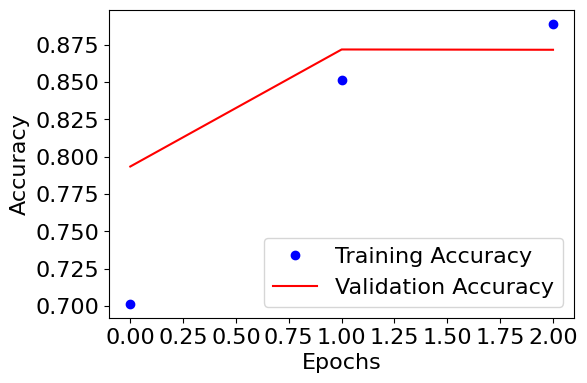

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))
epochs_list = range(epochs)
train_acc = history.history['acc']
valid_acc = history.history['val_acc']
plt.plot(epochs_list, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs_list, valid_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

#plt.tight_layout(pad=3)
fig.savefig('imdb_rnn_acc.pdf', format='pdf', dpi=1200)

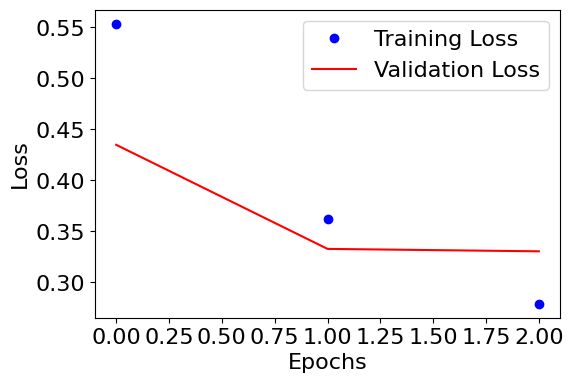

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))
epochs_list = range(epochs)
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(epochs_list, train_loss, 'bo', label='Training Loss')
plt.plot(epochs_list, valid_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

#plt.tight_layout(pad=8.0)
fig.savefig('imdb_rnn_loss.pdf', format='pdf', dpi=1200)

In [17]:
loss_and_acc = model.evaluate(x_test, numpy.array(labels_test))
print('loss = ' + str(loss_and_acc[0]))
print(f'acc = ' + str(loss_and_acc[1]))

782/782 [==============================] - 9s 11ms/step - loss: 0.3428 - acc: 0.8647
loss = 0.3427561819553375
acc = 0.8647199869155884


In [18]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding, Dense, Flatten 

vocabulary = 10000
embedding_dim = 32
word_num = 500
state_dim = 32

model = Sequential()
model.add(Embedding(vocabulary, embedding_dim, input_length=word_num))
model.add(SimpleRNN(state_dim, return_sequences=True))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 500, 32)           2080      
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 16001     
                                                                 
Total params: 338081 (1.29 MB)
Trainable params: 338081 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
from keras import optimizers

epochs = 3

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=epochs,
                    batch_size=32, validation_data=(x_valid, y_valid))

Epoch 1/3
625/625 [==============================] - 39s 59ms/step - loss: 0.4989 - acc: 0.7252 - val_loss: 0.3106 - val_acc: 0.8752
Epoch 2/3
625/625 [==============================] - 36s 57ms/step - loss: 0.2242 - acc: 0.9099 - val_loss: 0.3488 - val_acc: 0.8510
Epoch 3/3
625/625 [==============================] - 36s 58ms/step - loss: 0.1089 - acc: 0.9607 - val_loss: 0.4085 - val_acc: 0.8556


In [20]:
loss_and_acc = model.evaluate(x_test, numpy.array(labels_test))
print('loss = ' + str(loss_and_acc[0]))
print('acc = ' + str(loss_and_acc[1]))

782/782 [==============================] - 9s 11ms/step - loss: 0.4192 - acc: 0.8460
loss = 0.41920140385627747
acc = 0.8460000157356262


# 5. LSTM

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Flatten

vocabulary = 10000
embedding_dim = 32
word_num = 500
state_dim = 32

model = Sequential()
model.add(Embedding(vocabulary, embedding_dim, input_length=word_num))
model.add(LSTM(state_dim, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
from keras import optimizers

epochs = 10

model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=epochs,
                    batch_size=32, validation_data=(x_valid, y_valid))

Epoch 1/10
625/625 [==============================] - 55s 84ms/step - loss: 0.4403 - acc: 0.7901 - val_loss: 0.2906 - val_acc: 0.8820
Epoch 2/10
625/625 [==============================] - 51s 82ms/step - loss: 0.2759 - acc: 0.8936 - val_loss: 0.2813 - val_acc: 0.8862
Epoch 3/10
625/625 [==============================] - 51s 81ms/step - loss: 0.2310 - acc: 0.9135 - val_loss: 0.3261 - val_acc: 0.8724
Epoch 4/10
625/625 [==============================] - 51s 81ms/step - loss: 0.2011 - acc: 0.9258 - val_loss: 0.2824 - val_acc: 0.8922
Epoch 5/10
625/625 [==============================] - 51s 82ms/step - loss: 0.1787 - acc: 0.9330 - val_loss: 0.3094 - val_acc: 0.8786
Epoch 6/10
625/625 [==============================] - 51s 82ms/step - loss: 0.1659 - acc: 0.9395 - val_loss: 0.3018 - val_acc: 0.8926
Epoch 7/10
625/625 [==============================] - 53s 85ms/step - loss: 0.1522 - acc: 0.9463 - val_loss: 0.3117 - val_acc: 0.8900
Epoch 8/10
625/625 [==============================] - 53s 84ms

In [23]:
loss_and_acc = model.evaluate(x_test, numpy.array(labels_test))
print('loss = ' + str(loss_and_acc[0]))
print('acc = ' + str(loss_and_acc[1]))

782/782 [==============================] - 20s 26ms/step - loss: 0.4137 - acc: 0.8653
loss = 0.4137340188026428
acc = 0.8652799725532532


In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Flatten

vocabulary = 10000
embedding_dim = 32
word_num = 500
state_dim = 32

model = Sequential()
model.add(Embedding(vocabulary, embedding_dim, input_length=word_num))
model.add(LSTM(state_dim, return_sequences=False, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           320000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328353 (1.25 MB)
Trainable params: 328353 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
from keras import optimizers

epochs = 10

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=epochs,
                    batch_size=32, validation_data=(x_valid, y_valid))

Epoch 1/10
625/625 [==============================] - 63s 97ms/step - loss: 0.6923 - acc: 0.5505 - val_loss: 0.6904 - val_acc: 0.6120
Epoch 2/10
625/625 [==============================] - 60s 96ms/step - loss: 0.6537 - acc: 0.6700 - val_loss: 0.5729 - val_acc: 0.7412
Epoch 3/10
625/625 [==============================] - 62s 100ms/step - loss: 0.4991 - acc: 0.7925 - val_loss: 0.4469 - val_acc: 0.8254
Epoch 4/10
625/625 [==============================] - 62s 100ms/step - loss: 0.3777 - acc: 0.8527 - val_loss: 0.3542 - val_acc: 0.8574
Epoch 5/10
625/625 [==============================] - 56s 90ms/step - loss: 0.3061 - acc: 0.8831 - val_loss: 0.3132 - val_acc: 0.8748
Epoch 6/10
625/625 [==============================] - 62s 100ms/step - loss: 0.2709 - acc: 0.8967 - val_loss: 0.2969 - val_acc: 0.8804
Epoch 7/10
625/625 [==============================] - 57s 90ms/step - loss: 0.2445 - acc: 0.9087 - val_loss: 0.2837 - val_acc: 0.8850
Epoch 8/10
625/625 [==============================] - 55s 8

In [26]:
loss_and_acc = model.evaluate(x_test, numpy.array(labels_test))
print('loss = ' + str(loss_and_acc[0]))
print('acc = ' + str(loss_and_acc[1]))

782/782 [==============================] - 24s 30ms/step - loss: 0.2838 - acc: 0.8877
loss = 0.2837585508823395
acc = 0.8876799941062927


In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

vocabulary = 10000
embedding_dim = 32
word_num = 500
state_dim = 32

model = Sequential()
model.add(Embedding(vocabulary, embedding_dim, input_length=word_num))
model.add(LSTM(state_dim, return_sequences=True, dropout=0.2))
model.add(LSTM(state_dim, return_sequences=True, dropout=0.2))
model.add(LSTM(state_dim, return_sequences=False, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 32)           320000    
                                                                 
 lstm_2 (LSTM)               (None, 500, 32)           8320      
                                                                 
 lstm_3 (LSTM)               (None, 500, 32)           8320      
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 344993 (1.32 MB)
Trainable params: 344993 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
from keras import optimizers

epochs = 10

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=epochs,
                    batch_size=32, validation_data=(x_valid, y_valid))

Epoch 1/10
625/625 [==============================] - 195s 302ms/step - loss: 0.5164 - acc: 0.7157 - val_loss: 0.3440 - val_acc: 0.8662
Epoch 2/10
625/625 [==============================] - 157s 252ms/step - loss: 0.3029 - acc: 0.8796 - val_loss: 0.3218 - val_acc: 0.8640
Epoch 3/10
625/625 [==============================] - 169s 271ms/step - loss: 0.2478 - acc: 0.9050 - val_loss: 0.3252 - val_acc: 0.8588
Epoch 4/10
625/625 [==============================] - 186s 297ms/step - loss: 0.2172 - acc: 0.9200 - val_loss: 0.2740 - val_acc: 0.8914
Epoch 5/10
625/625 [==============================] - 191s 305ms/step - loss: 0.1955 - acc: 0.9291 - val_loss: 0.2749 - val_acc: 0.8886
Epoch 6/10
625/625 [==============================] - 170s 272ms/step - loss: 0.1785 - acc: 0.9356 - val_loss: 0.2807 - val_acc: 0.8896
Epoch 7/10
625/625 [==============================] - 151s 241ms/step - loss: 0.1609 - acc: 0.9429 - val_loss: 0.2959 - val_acc: 0.8854
Epoch 8/10
625/625 [============================

In [29]:
loss_and_acc = model.evaluate(x_test, numpy.array(labels_test))
print('loss = ' + str(loss_and_acc[0]))
print('acc = ' + str(loss_and_acc[1]))

782/782 [==============================] - 80s 102ms/step - loss: 0.5142 - acc: 0.8494
loss = 0.5142177939414978
acc = 0.849399983882904


# 6. Bi-LSTM

In [30]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Bidirectional

vocabulary = 10000
embedding_dim = 32
word_num = 500
state_dim = 32

model = Sequential()
model.add(Embedding(vocabulary, embedding_dim, input_length=word_num))
model.add(Bidirectional(LSTM(state_dim, return_sequences=False, dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 32)           320000    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 336705 (1.28 MB)
Trainable params: 336705 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
from keras import optimizers

epochs = 3

model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=epochs,
                    batch_size=32, validation_data=(x_valid, y_valid))

Epoch 1/3
625/625 [==============================] - 86s 129ms/step - loss: 0.4829 - acc: 0.7582 - val_loss: 0.3142 - val_acc: 0.8700
Epoch 2/3
625/625 [==============================] - 77s 124ms/step - loss: 0.2909 - acc: 0.8843 - val_loss: 0.3332 - val_acc: 0.8592
Epoch 3/3
625/625 [==============================] - 66s 106ms/step - loss: 0.2405 - acc: 0.9095 - val_loss: 0.2898 - val_acc: 0.8806


In [33]:
loss_and_acc = model.evaluate(x_test, numpy.array(labels_test))
print('loss = ' + str(loss_and_acc[0]))
print('acc = ' + str(loss_and_acc[1]))

782/782 [==============================] - 26s 33ms/step - loss: 0.2952 - acc: 0.8810
loss = 0.2951814532279968
acc = 0.8809999823570251
